In [1]:
from skimage import io, measure, filters, color
from skimage.segmentation import clear_border
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from scipy.spatial import cKDTree
import seaborn as sns
import pickle as pkl
from adjustText import adjust_text
from scipy.spatial import distance
import anndata as ad

### Find and export contours of cysts (pre-segmented) + area

In [53]:
library = 'pkd_3'
slide = 'A4'

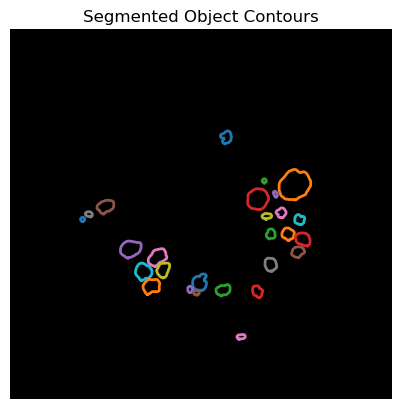

In [54]:
# Load the segmentation mask
img_greyscale = io.imread(f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Raw_Data/Raw_Slide_Images/{slide}_segmented_cyst.tif')[..., 0]

threshold = filters.threshold_otsu(img_greyscale)
mask = img_greyscale > threshold

# Remove artifacts connected to image border
cleared = clear_border(mask)

# Label the distinct regions in the mask
labeled_mask = measure.label(cleared)

# Dictionary to store coordinates for each label
label_coords = {}
# Dictionary to store area for each label
label_areas = {}

canvas = np.zeros_like(mask)

# Loop through each identified object
for region in measure.regionprops(labeled_mask):
    # Mask for the current object
    object_mask = labeled_mask == region.label

    # Find contours for the current object
    contours = measure.find_contours(object_mask, level=0.5)

    # Plot the first contour if present
    if contours:
        contour = contours[0]
        # The coordinates are in (row, col) format -> convert to (x, y)
        x, y = contour[:, 1], contour[:, 0]
        plt.plot(x, y, linewidth=2)  # Adjust linewidth as needed

        # Also store these coordinates in a list of (y, x) tuples
        # (This matches your original code)
        xy_coords = contour[:, [1, 0]]
        label_coords[region.label] = [(y_, x_) for x_, y_ in xy_coords]

    # Store the area in pixels for this region
    label_areas[region.label] = region.area

# Display the plot
plt.imshow(canvas, cmap='gray')
plt.title('Segmented Object Contours')
plt.axis('off')
plt.show()

# Create a DataFrame that includes both the coordinates and the area in pixels
data = []
for label, coords in label_coords.items():
    data.append((label, coords, label_areas[label]))

contours_df = pd.DataFrame(data, columns=['label', 'coordinates', 'area_in_pixels'])

In [55]:
segmented_data = pd.read_csv(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/{library}_tangram_segmented_nuclei_data_withPKD.csv")

In [56]:
low_res = {
'Immune': ['Neutro', 'Fib', 'NK', 'Macro', 'B lymph', 'B1 B lymph', 'T lymph', 'DC', 'NKT1', 'Lyc6 low Macrophages', 'Lyc6 high Macrophages','Spp1+ Resident Macrophages ', 'Mrc1+ Resident Macrophages', 'Gzma+ NK', 'Gzma+ CD8+ T lymph', 'Memory B lymph', 'CD4+ T lymph', 'CD4+ Th17', 'CD4+ T regs', 'B1 B lymph', 'T3/Follicular B lymph', 'T1 B lymph', 'Gzma low NK'],
'Endo': ['Endo', 'Glom-Endo', 'Asc-Vasa-Recta', 'Vas-Efferens', 'Desc-Vasa-Recta', 'Vas-Afferens'],
'PT': ['PTS1', 'PTS2', 'PTS3', 'PTS3T2'],
'LOH': ['TAL', 'ATL', 'DTL', 'DTL-ATL'],
'DCT': ['DCT', 'DCT-CNT']}

In [57]:
low_res_rev = {vs: k for k, v in low_res.items() for vs in v}

In [59]:
segmented_data['low_res_cell_type'] = segmented_data['cluster'].replace(low_res_rev)

In [60]:
contours_df

,label,coordinates,area_in_pixels
0,1,"[(5854.5, 11023.0), (5854.5, 11022.0), (5854.5...",249036.0
1,2,"[(8730.5, 14603.0), (8730.5, 14602.0), (8730.5...",1881223.0
2,3,"[(7870.5, 13040.0), (7870.5, 13039.0), (7870.5...",35652.0
3,4,"[(9238.5, 12800.0), (9238.5, 12799.0), (9238.5...",904034.0
4,5,"[(8589.5, 13643.0), (8589.5, 13642.0), (8589.5...",44676.0
5,6,"[(9454.5, 4794.0), (9454.5, 4793.0), (9454.5, ...",422299.0
6,7,"[(9646.5, 13956.0), (9646.5, 13955.0), (9646.5...",179682.0
7,8,"[(9604.5, 4127.0), (9604.5, 4126.0), (9604.5, ...",73323.0
8,9,"[(9722.5, 13129.0), (9722.5, 13128.0), (9722.5...",105924.0
9,10,"[(10006.5, 14912.0), (10006.5, 14911.0), (1000...",198294.0


In [61]:
points = []
labels = []
for row in contours_df.itertuples():
    # row.label is the cyst label
    # row.contour_coordinates is a list of (x, y) points
    for (x, y) in row.coordinates:
        points.append([x, y])
        labels.append(row.label)

# Convert to numpy array to build the KD-Tree
points_array = np.array(points)
contour_tree = cKDTree(points_array)

# For convenience, create a dictionary to map label -> area
label_to_area = dict(zip(contours_df['label'], contours_df['area_in_pixels']))

def get_distance_and_label(nucleus, tree, points_labels):
    """
    Return the nearest distance and the label of the cyst that point belongs to.
    """
    x_nucleus, y_nucleus = nucleus['x'], nucleus['y']
    distance, index = tree.query([x_nucleus, y_nucleus])
    # index is the position in 'points_array'; that same position in 'points_labels'
    # tells us which cyst label it belongs to.
    label = points_labels[index]
    return distance, label

# We'll apply this function to each row in segmented_data, which contains columns 'x' and 'y'
results = segmented_data.apply(
    lambda row: get_distance_and_label(row, contour_tree, labels),
    axis=1
)
segmented_data[['closest_cyst_distance', 'closest_cyst_label']] = pd.DataFrame(results.tolist(), index=results.index)

# Now map the label to the cyst area
segmented_data['closest_cyst_area'] = segmented_data['closest_cyst_label'].map(label_to_area)

In [62]:
random_array = np.random.rand(len(segmented_data), 4)

In [63]:
adata_segment = ad.AnnData(random_array, obs=segmented_data)

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [64]:
adata_segment.obsm['spatial'] = segmented_data[['y', 'x']].values

In [65]:
adata_segment.uns['spatial'] = dict()

In [90]:
import pickle
with open(f'/exports/humgen/cnovellarausell/SevtapSpatial/adata_uns_spatial_{library}.pickle', 'rb') as handle:
    adata_segment.uns['spatial'][f'{library}'] = pickle.load(handle)

In [66]:
adata_segment.obs['closest_cyst_label'] = adata_segment.obs['closest_cyst_label'].astype('category')

[<Axes: title={'center': 'closest_cyst_distance'}, xlabel='spatial1', ylabel='spatial2'>]

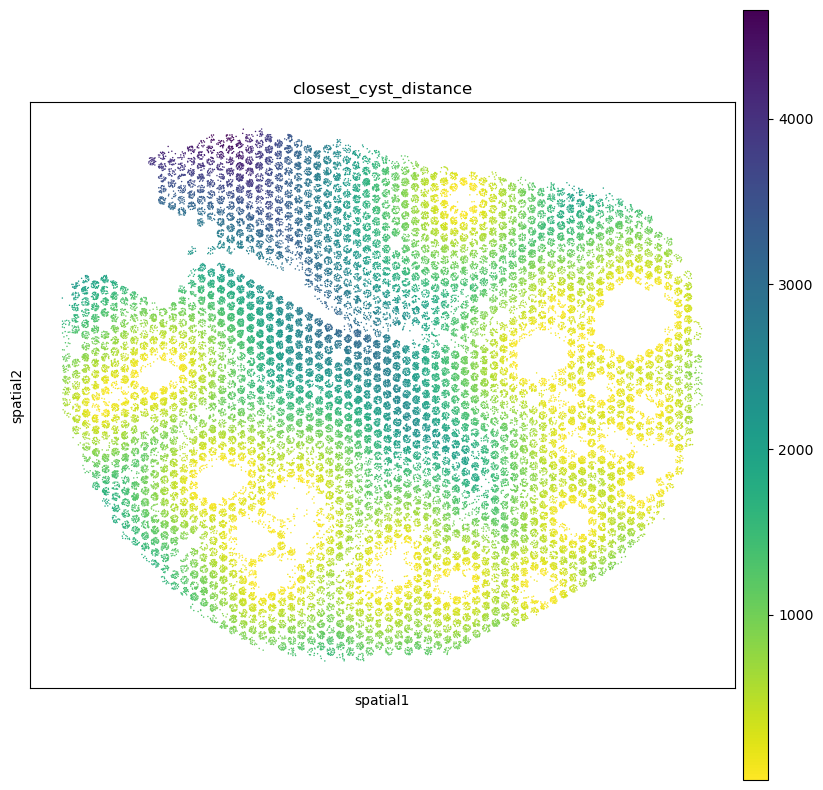

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.spatial(
    adata_segment,
    library_id=f'{library}',
    color="closest_cyst_distance",
    size=0.2,
    show=False,
    frameon=True,
    #palette=palette,
    alpha_img=0,
    legend_fontsize=20,
    ax=ax,
    cmap='viridis_r'
)
#plt.savefig("/exports/humgen/cnovellarausell/SevtapSpatial/Deconvoluted_distance_to_cyst_pkd_3.pdf", bbox_inches='tight')

In [94]:
adata_segment.write_h5ad(f"/exports/humgen/cnovellarausell/SevtapSpatial/{library}_segment_with_distances_withPKD.h5ad")